In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
seed = 0
np.random.seed(seed)

#### FYI: The classification problem below is very easy to solve, but due to the limited number of features it is useful to showcase how one can use a Tree Feature Generator.  A more difficult problem would be nicer!

In [2]:
#skin dataset - 3 features and 1 target
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt'
skin_data_raw = pd.read_csv(url,sep='\t',names=['x1','x2','x3','target'])
skin_data_raw['target']=skin_data_raw['target'].map({1:0,2:1})

In [3]:
skin_data_raw.head(5)

,x1,x2,x3,target
0,74,85,123,0
1,73,84,122,0
2,72,83,121,0
3,70,81,119,0
4,70,81,119,0


In [4]:
skin_data_raw['target'].unique()

array([0, 1])

In [5]:
X = skin_data_raw.values[:,:3]
y = skin_data_raw.values[:,3]

In [6]:
from sklearn.model_selection import train_test_split
#X_test,y_test used for final model evaluation
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [7]:
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score

In [8]:
#a function which summarizes results of a classifier
#input is true y labels and the predicted labels
def summarize_performance(y_true,y_pred,y_pred_proba):
    acc_score = accuracy_score(y_true,y_pred)
    prec_score = precision_score(y_true,y_pred)
    rec_score = recall_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)
    auc = roc_auc_score(y_true,y_pred)

    print('accuracy: %0.6f'%(acc_score))
    print('precision: %0.6f'%(prec_score))
    print('recall: %0.6f'%(rec_score))
    print('f1: %0.6f'%(f1))
    print('auc: %0.6f'%(auc))

In [9]:
#a function which computes true positives and false positives arrays and an AUC score for a particular model
#inputs are the true y labels and array of predicted values generated by the model
def generate_tp_fp_auc(y_true,y_pred_proba):
    y_pred_proba = y_pred_proba[:,1]
    #computing false and true positive rates
    fpr, tpr, _ = roc_curve(y_true,y_pred_proba)
    #computing the area under the curve
    roc_auc = auc(fpr, tpr)
    #roc_auc = roc_auc_score(y_true,y_pred_proba)
    return fpr, tpr, roc_auc

#### Building RF model

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
#limiting the performance of the RF by setting max depth of 5 in order for the ROC results in the end to be legible
#otherwise the models perform evently (the problem is just really easy to solve)
#max_depth pf 5 results in shallower trees => lower variance across trees
rfv = RandomForestClassifier(n_estimators=10,max_depth=5)

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
#cross_val score for the Random Forest model (using F1)
f1_scores = cross_val_score(rfv, X_train, y_train,cv=10,scoring='f1')
print('Mean 10CV F1 Score: %0.5f' %(f1_scores.mean()))
print('Std 10CV F1 Score: %0.5f' %(f1_scores.std()))

Mean 10CV F1 Score: 0.99050
Std 10CV F1 Score: 0.00142


In [14]:
#training the RF on the train portion of the data
rfv.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
#generating a model prediction using the train/test set
y_pred_rfv_train = rfv.predict(X_train)
y_pred_rfv_train_proba = rfv.predict_proba(X_train)
y_pred_rfv_test = rfv.predict(X_test)
y_pred_rfv_test_proba = rfv.predict_proba(X_test)

In [16]:
#train data performance
summarize_performance(y_train,y_pred_rfv_train,y_pred_rfv_train_proba)

accuracy: 0.986351
precision: 0.999328
recall: 0.983433
f1: 0.991317
auc: 0.990456


In [17]:
#test data performance
summarize_performance(y_test,y_pred_rfv_test,y_pred_rfv_test_proba)

accuracy: 0.985742
precision: 0.999033
recall: 0.982969
f1: 0.990936
auc: 0.989664


In [18]:
#calculating true and false positives for the RF for an ROC visualization
fpr_rfv, tpr_rfv, auc_rfv = generate_tp_fp_auc(y_test,y_pred_rfv_test_proba)

#### Building a Vanilla (untunned) Gradient Boosted model

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
#limiting the performance of the GBT by setting n_estimators=10 in order for the ROC results in the end 
#to be legible otherwise the models perform evently (the problem is just really easy to solve)
#the trees by default in boosting are shallower, so limiting the number of trees results in weaker 
#ensemble performance (compared to a RF)
grdbv = GradientBoostingClassifier(n_estimators = 10)

In [21]:
#cross_val score for the Gradient Boosting Model (using F1)
f1_scores = cross_val_score(grdbv, X_train, y_train,cv=10,scoring='f1')
print('Mean 10CV F1 Score: %0.5f' %(f1_scores.mean()))
print('Std 10CV F1 Score: %0.5f' %(f1_scores.std()))

Mean 10CV F1 Score: 0.97928
Std 10CV F1 Score: 0.00085


In [22]:
#training the GB model on the train portion of the data
grdbv.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [23]:
#generating a model prediction using the train/test set
y_pred_grdbv_train = grdbv.predict(X_train)
y_pred_grdbv_train_proba = grdbv.predict_proba(X_train)
y_pred_grdbv_test = grdbv.predict(X_test)
y_pred_grdbv_test_proba = grdbv.predict_proba(X_test)

In [24]:
#train data performance
summarize_performance(y_train,y_pred_grdbv_train,y_pred_grdbv_train_proba)

accuracy: 0.967811
precision: 0.988186
recall: 0.970980
f1: 0.979507
auc: 0.963354


In [25]:
#test data performance
summarize_performance(y_test,y_pred_grdbv_test,y_pred_grdbv_test_proba)

accuracy: 0.966600
precision: 0.987738
recall: 0.969914
f1: 0.978745
auc: 0.961915


In [26]:
#calculating true and false positives for the GB model for an ROC visualization
fpr_grdbv, tpr_grdbv, auc_grdbv = generate_tp_fp_auc(y_test,y_pred_grdbv_test_proba)

#### Building a vanilla Linear Model using the data

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
#logistic regression by itself
lm = LogisticRegression()

In [29]:
#cross_val score for the LM Model (using F1)
f1_scores = cross_val_score(lm, X_train, y_train,cv=10,scoring='f1')
print('Mean 10CV F1 Score: %0.5f' %(f1_scores.mean()))
print('Std 10CV F1 Score: %0.5f' %(f1_scores.std()))

Mean 10CV F1 Score: 0.94876
Std 10CV F1 Score: 0.00139


In [30]:
#fitting the linear model to all of the X_train data
lm.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
#generating a model prediction using the train/test set
y_pred_lm_train = lm.predict(X_train)
y_pred_lm_train_proba = lm.predict_proba(X_train)
y_pred_lm_test = lm.predict(X_test)
y_pred_lm_test_proba = lm.predict_proba(X_test)

In [32]:
#train data performance
summarize_performance(y_train,y_pred_lm_train,y_pred_lm_train_proba)

accuracy: 0.919324
precision: 0.953668
recall: 0.944035
f1: 0.948827
auc: 0.884557


In [33]:
#test data performance
summarize_performance(y_test,y_pred_lm_test,y_pred_lm_test_proba)

accuracy: 0.918782
precision: 0.954064
recall: 0.942964
f1: 0.948481
auc: 0.884597


In [34]:
#calculating true and false positives for the LM model for an ROC visualization
fpr_lm, tpr_lm, auc_lm = generate_tp_fp_auc(y_test,y_pred_lm_test_proba)

#### Building a vanilla version of the Tree Feature Generator Model

In [35]:
from tree_feature_transformation import TreeTransformClf 

In [36]:
tftrc = TreeTransformClf()

In [37]:
#cross_val score for the tree feature transformer model (using F1)
f1_scores = cross_val_score(tftrc, X_train, y_train,cv=10,scoring='f1')
print('Mean 10CV F1 Score: %0.5f' %(f1_scores.mean()))
print('Std 10CV F1 Score: %0.5f' %(f1_scores.std()))

Mean 10CV F1 Score: 0.99887
Std 10CV F1 Score: 0.00031


In [38]:
#training the feature transformer model on the train portion of the data
tftrc.fit(X_train,y_train)

In [39]:
#generating a model prediction using the train/test set
y_pred_tftrc_train = tftrc.predict(X_train)
y_pred_tftrc_train_proba = tftrc.predict_proba(X_train)
y_pred_tftrc_test = tftrc.predict(X_test)
y_pred_tftrc_test_proba = tftrc.predict_proba(X_test)

In [40]:
#train data performance
summarize_performance(y_train,y_pred_tftrc_train,y_pred_tftrc_train_proba)

accuracy: 0.998922
precision: 0.999869
recall: 0.998770
f1: 0.999319
auc: 0.999136


In [41]:
#test data performance
summarize_performance(y_test,y_pred_tftrc_test,y_pred_tftrc_test_proba)

accuracy: 0.998491
precision: 0.999688
recall: 0.998409
f1: 0.999048
auc: 0.998608


In [42]:
#calculating true and false positives for the LM model for an ROC visualization
fpr_tftrc, tpr_tftrc, auc_tftrc = generate_tp_fp_auc(y_test,y_pred_tftrc_test_proba)

#### Visualizing AUC across the various models

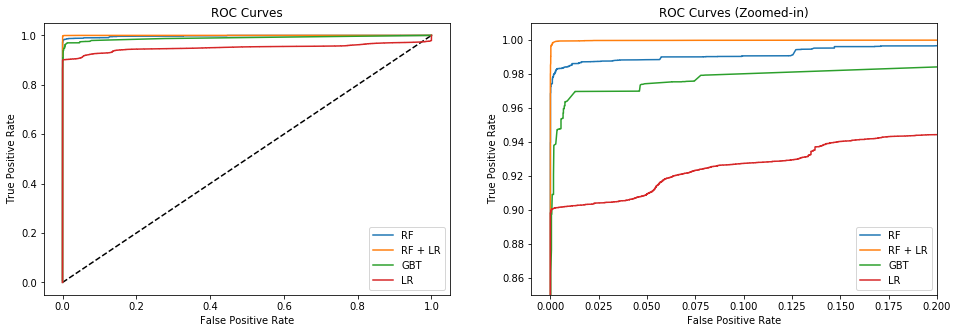

In [43]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rfv, tpr_rfv, label='RF')
plt.plot(fpr_tftrc, tpr_tftrc, label='RF + LR')
plt.plot(fpr_grdbv, tpr_grdbv, label='GBT')
plt.plot(fpr_lm, tpr_lm,label='LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.xlim(-0.01, 0.2)
plt.ylim(0.85, 1.01)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_rfv, tpr_rfv, label='RF')
plt.plot(fpr_tftrc, tpr_tftrc, label='RF + LR')
plt.plot(fpr_grdbv, tpr_grdbv, label='GBT')
plt.plot(fpr_lm, tpr_lm,label='LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Zoomed-in)')
plt.legend(loc='lower right')

plt.show()

#### Example of how the Tree Feature Generator Model can be tuned through Grid Search

In [44]:
clf = TreeTransformClf(tree_clf=RandomForestClassifier(),
                       meta_clf=LogisticRegression(),
                       blend_split=0.5,
                       random_state=0)

In [48]:
from sklearn.model_selection import GridSearchCV

In [58]:
param_grid = {"tree_clf__max_depth":[3,5,None],
              "tree_clf__max_features":[1,2,3],
              "tree_clf__random_state" : [0],
              "tree_clf__n_jobs" : [-1],
              "meta_clf__penalty" : ['l1','l2'],
              "meta_clf__C" : [10,1,0.1,0.001]}

In [59]:
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)

In [60]:
grid_search.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=TreeTransformClf(blend_split=0.5,
         meta_clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          ve... n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tree_clf__max_features': [1, 2, 3], 'meta_clf__penalty': ['l1', 'l2'], 'tree_clf__max_depth': [3, 5, None], 'tree_clf__random_state': [0], 'tree_clf__n_jobs': [-1], 'meta_clf__C': [10, 1, 0.1, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
grid_search.best_params_

{'meta_clf__C': 1,
 'meta_clf__penalty': 'l1',
 'tree_clf__max_depth': None,
 'tree_clf__max_features': 2,
 'tree_clf__n_jobs': -1,
 'tree_clf__random_state': 0}

In [64]:
grid_search.best_score_

0.97079863052269477

#### Pipeline and GridSearch integration example

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [66]:
pipe = Pipeline([('pca',PCA()),
                 ('clf',TreeTransformClf(tree_clf=RandomForestClassifier(),meta_clf=LogisticRegression()))])

In [70]:
param_grid = {"pca__n_components" : [2,3],
              "clf__tree_clf__max_depth":[3,5,None],
              "clf__tree_clf__max_features":[1,2],
              "clf__tree_clf__random_state" : [0],
              "clf__tree_clf__n_jobs" : [-1],
              "clf__meta_clf__penalty" : ['l1','l2'],
              "clf__meta_clf__C" : [10,1,0.1,0.001]}

In [71]:
grid_search =  GridSearchCV(pipe, param_grid=param_grid)

In [72]:
grid_search.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', TreeTransformClf(blend_split=0.5,
         meta_clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scalin..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__tree_clf__max_depth': [3, 5, None], 'pca__n_components': [2, 3], 'clf__tree_clf__random_state': [0], 'clf__meta_clf__penalty': ['l1', 'l2'], 'clf__tree_clf__max_features': [1, 2], 'clf__tree_clf__n_jobs': [-1], 'clf__meta_clf__C': [10, 1, 0.1, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
grid_search.best_params_

{'clf__meta_clf__C': 0.1,
 'clf__meta_clf__penalty': 'l2',
 'clf__tree_clf__max_depth': 5,
 'clf__tree_clf__max_features': 2,
 'clf__tree_clf__n_jobs': -1,
 'clf__tree_clf__random_state': 0,
 'pca__n_components': 3}

In [74]:
grid_search.best_score_

0.99002272940581171

#### Examples of using tree models other than RF for feature generation

In [75]:
from sklearn.ensemble import RandomTreesEmbedding, GradientBoostingClassifier, ExtraTreesClassifier

In [76]:
clf = TreeTransformClf(tree_clf=GradientBoostingClassifier(),
                       meta_clf=LogisticRegression(),
                       blend_split=0.5,
                       random_state=0)

In [77]:
#mean CV F1 score with GB
cross_val_score(clf, X_train, y_train, cv=10,scoring='f1').mean()

0.99909620390117215

In [78]:
clf = TreeTransformClf(tree_clf=ExtraTreesClassifier(),
                       meta_clf=LogisticRegression(),
                       blend_split=0.5,
                       random_state=0)

In [79]:
#mean CV F1 score with Extra Trees
cross_val_score(clf, X_train, y_train, cv=10,scoring='f1').mean()

0.99953853754668676

In [80]:
clf = TreeTransformClf(tree_clf=RandomTreesEmbedding(),
                       meta_clf=LogisticRegression(),
                       blend_split=0.5,
                       random_state=0)

In [81]:
#mean CV F1 score with Tree Embedding
cross_val_score(clf, X_train, y_train, cv=10,scoring='f1').mean()

0.9959746573179078